# What do the pdf updates look like?

Exploring how the input distribution changes under Fisher information updates.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib

In [2]:
from discriminationAnalysis import Fisher_smooth_fits
from basicModel import EstimateAngle

from adapt_fit_loop import moving_average

## pdf update for the concentrated case

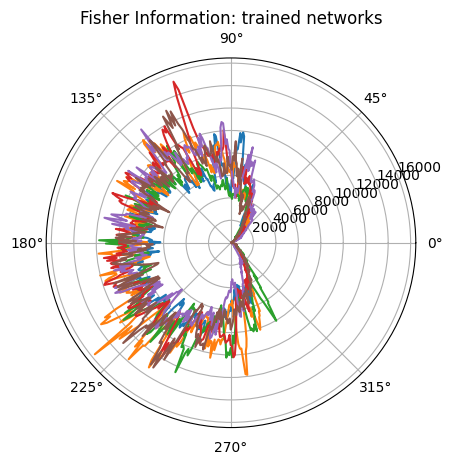

In [3]:
import glob

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: trained networks')

ex4_conc_dir = 'trainedParameters/Exp4_conc/'

FIcurves_conc = []

for rep in range(6):
    trained_ckpt =  glob.glob(ex4_conc_dir + f'rep{rep}/epoch*')[0]
    
    model = EstimateAngle.load_from_checkpoint(trained_ckpt)

    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    FIcurves_conc.append(fi)
    
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

In [4]:
np.array(FIcurves_conc).min(1)

array([14.69482853,  9.7832375 ,  0.17993534, 17.95820599, 25.27543399,
       18.58125288])

In [ ]:
fisher_curves = np.array(FIcurves_conc)

smoothed_mean_fisher = moving_average(np.mean(fisher_curves, axis=0))

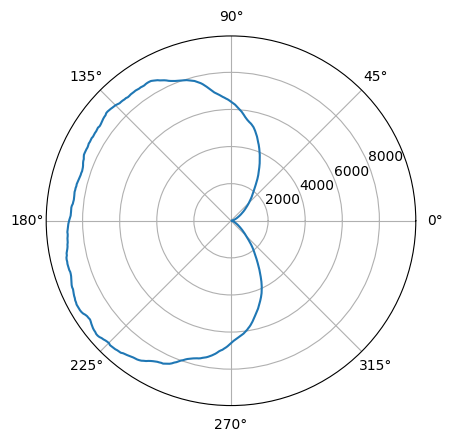

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(np.linspace(0, 2*np.pi, 500), smoothed_mean_fisher)

In [ ]:
unif = np.ones(500)

p1 = unif / smoothed_mean_fisher**0.5
p1 = p1 / p1.sum()

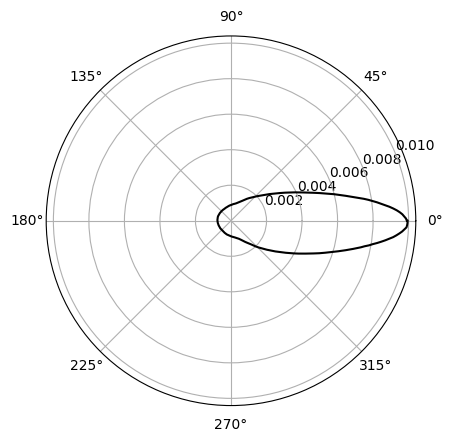

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 
plt.plot(np.linspace(0, 2*np.pi, 500), p1, 'k')

Experiment 4 concentrated was trained with the data concentrated around pi /2.

Note for these plots, I am doubling the angular scale for ease of visualization of the periodic signal. Thus, angles close to zero are, in fact, orthogonal to the pi/2 angles.

What is the idea of the iteration?
1. this network has its Fisher information concentrated at pi/2.
2. fine-tuning on the reverse, concentrated around 0, should, thus, remove this sensitivity bias.

Finetuning what? Should we finetune this network (the already trained one), or the previous network that we trained in order to get this response to the current stimulus distribution?




#### Note for the record:
These are seperately trained versions of the network that we are averaging over to determine the Fisher information.

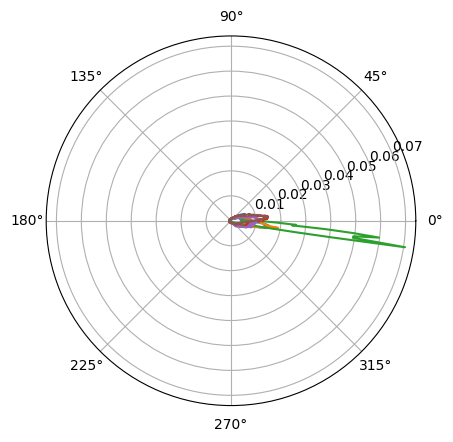

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 
for fi in FIcurves_conc:
    c = unif / fi**0.5
    plt.plot(np.linspace(0, 2*np.pi, 500), c / c.sum())


The individual runs can produce very noisy results.

### Ideas as to why the convergence fails:

1. There are modes that are amplified, rather than damped in the fitting process.
   - essentially this is the case if the distribution above is more extreme than the distribution that the network was trained on.

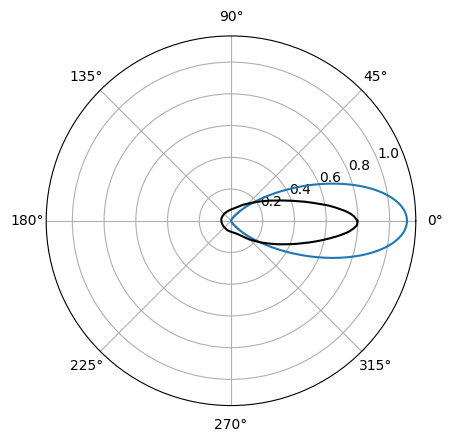

In [ ]:
from scipy.stats import vonmises
from scipy.integrate import trapezoid

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

x = np.linspace(0, 2*np.pi, 500)


p1 = unif / smoothed_mean_fisher**0.5
p1 = p1 / trapezoid(p1, x)

plt.plot(x, vonmises(8., 0).pdf( x))
 
plt.plot(x, p1, 'k')

I have to be careful here about how these are normalized, and to what x domain. However, the fact that the values near zero are 'rounded out' is hopeful.

In [ ]:
from adaptableModel import AngleDistribution

In [ ]:
# this is the former default
a= AngleDistribution(p1, [-np.pi, np.pi])

In [ ]:
update_samples = a.sample(10000)
prior_samples =  vonmises(8., 0).rvs( 10000)

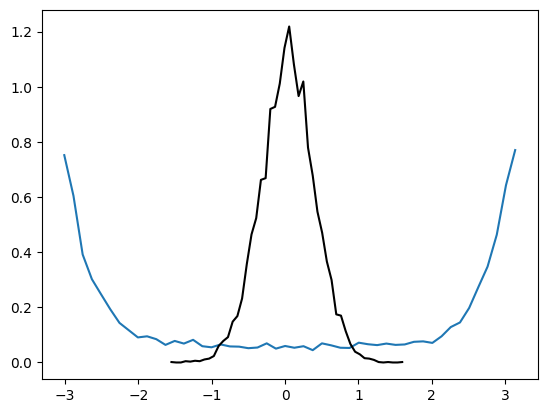

In [ ]:
n_update, b_update = np.histogram(update_samples, bins=50, density=True)
plt.plot(b_update[1:], n_update)

n_prior, b_prior = np.histogram(prior_samples, bins=50, density=True)
plt.plot(b_prior[1:], n_prior, 'k')

Ok, this is reasonable good to show the distribution is, in fact getting more uniform, at least for this one step.

In [ ]:
test = AngleDistribution( vonmises(8., 0).pdf( x), [-np.pi, np.pi])

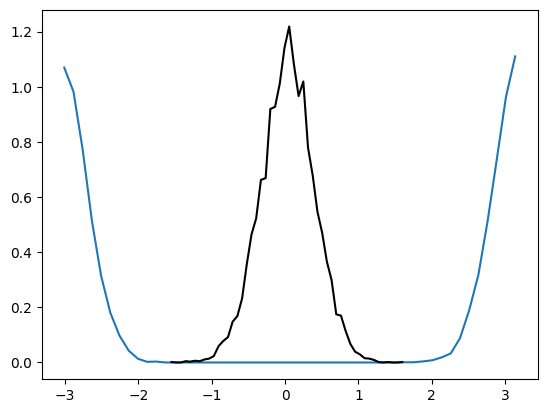

In [ ]:
test_num, test_bins = np.histogram(test.sample(10000), bins=50, density=True)

plt.plot(test_bins[1:], test_num)
plt.plot(b_prior[1:], n_prior, 'k')

#### These are possible issues:
- AngleDistribution appears to rotate the angles by 180 degrees
- AngleDistribution also uses angles betwee -pi and pi rather that 0 to pi (or some other half length parameterization), which is inconsistent with the generation.

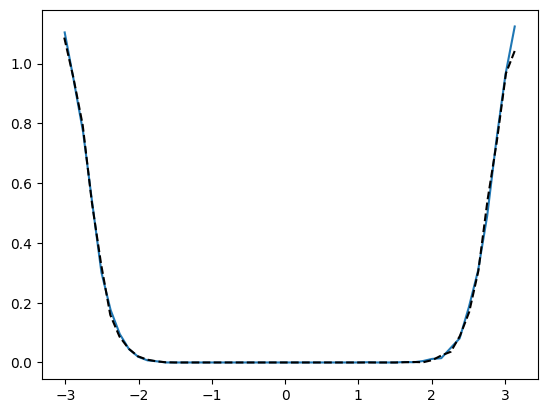

In [ ]:
test_num, test_bins = np.histogram(test.sample(10000), bins=50, density=True)
rotated_num, rotated_bins = np.histogram( vonmises(8.,np.pi).rvs(10000), bins=50, density=True)

plt.plot(test_bins[1:], test_num)
plt.plot(rotated_bins[1:], rotated_num, '--k')

The density itself seems reasonably unchanged.